# Effect of initial SOC in dvdq

Study the effect of initial starting SOC on dvdq peak height and position

3/21/2025

In [22]:
# Import the required libraries
import matplotlib.pyplot as plt
import numpy as np
import pybamm

In [23]:
NOM_CAPACITY = 5 # Ah

Mean power: 0.93 W
Discharge energy: 19.06 Wh


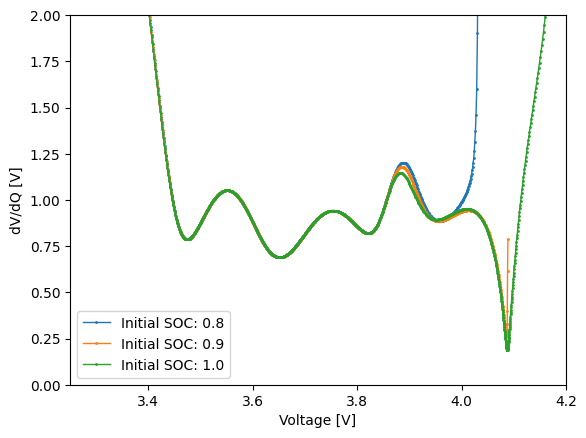

In [24]:
model = pybamm.lithium_ion.MPM()

params = pybamm.ParameterValues("Chen2020")

# Extract the radii values. We will choose these to be the means of our area-weighted distributions
R_a_n_dim = params["Negative particle radius [m]"]
R_a_p_dim = params["Positive particle radius [m]"]

# Standard deviations (dimensional)
sd_a_n_dim = 0.2 * R_a_n_dim
sd_a_p_dim = 0.6 * R_a_p_dim

# Minimum and maximum particle sizes (dimensional)
R_min_n = 0
R_min_p = 0
R_max_n = 2 * R_a_n_dim
R_max_p = 3 * R_a_p_dim

# Set the area-weighted particle-size distributions.
# Choose a lognormal (but any pybamm function could be used)


def f_a_dist_n_dim(R):
    return pybamm.lognormal(R, R_a_n_dim, sd_a_n_dim)


def f_a_dist_p_dim(R):
    return pybamm.lognormal(R, R_a_p_dim, sd_a_p_dim)


# Note: the only argument must be the particle size R
# input distribution params to the dictionary
distribution_params = {
    "Negative minimum particle radius [m]": R_min_n,
    "Positive minimum particle radius [m]": R_min_p,
    "Negative maximum particle radius [m]": R_max_n,
    "Positive maximum particle radius [m]": R_max_p,
    "Negative area-weighted " + "particle-size distribution [m-1]": f_a_dist_n_dim,
    "Positive area-weighted " + "particle-size distribution [m-1]": f_a_dist_p_dim,
}
params.update(distribution_params, check_already_exists=False)

experiment = pybamm.Experiment(
    ["Discharge at C/20 until 2.5V"]
    )

solver = pybamm.CasadiSolver(atol=1e-3, rtol=1e-3, mode="safe", dt_max=1)

sim = pybamm.Simulation(model=model,
                        parameter_values=params,
                        experiment=experiment,
                        solver=solver)

fig, ax = plt.subplots()

soc_vec = [0.8, 0.9, 1.0]
sol_vec = []

for soc_init in soc_vec:

    sol = sim.solve(initial_soc=soc_init)
    sol_vec.append(sol)

    time = sol["Time [s]"].data
    power = sol["Power [W]"].data
    voltage = sol["Voltage [V]"].data
    energy = np.cumsum(power * np.diff(np.append(0, time))) / 3600
    current = sol["Current [A]"].data

    capacity = np.cumsum(current * np.diff(np.append(0, time))) / 3600
    soc = 1 - capacity/NOM_CAPACITY
    dvdq = np.gradient(voltage)/np.gradient(soc)

    ax.plot(voltage, dvdq, 'o-', linewidth=1, markersize=1, label=f"Initial SOC: {soc_init}")

ax.set_xlabel("Voltage [V]")
ax.set_ylabel("dV/dQ [V]")
ax.set_ylim((0,2))
ax.set_xlim((3.25, 4.2))
ax.legend()
print(f"Mean power: {np.mean(power):.2f} W")
print(f"Discharge energy: {energy[-1]:.2f} Wh")

